# Sparse Embeddings with SPLADE
* Notebook by Adam Lang
* Date: 9/13/2024

# Overview
* In this notebook we will go over sparse embeddings with SPLADE.

# Sparse vs. Dense Embeddings

## Sparse Vectors
* Usually when we think of **sparse vectors** and embeddings we think of algorithms such as:
   * TF-IDF
   * BM-25
* Typically, these are known to have:
   * Very high dimensionality.
   * Lots of 0s (few non-zeros).
   * This means the information is "sparsely" located in the vector space.
   * Represent text and information at a word or sub-word (token) level.
      * This is why algorithms like TF-IDF or BM25 are still used today for search and recommendation systems because they excel at keyword search.
* PROS of Sparse Vectors
   * 1. Faster retrieval
   * 2. Excellent Baseline Performance
   * 3. No fine-tuning
   * 4. EXACT term matching (word level).
* CONS of Sparse Vectors
   * 1. Performance can't be improved over baseline training (not very flexible like dense embedding models).
   * 2. Usually suffer from the "vocabulary mismatch problem" where if the word is not in the training corpus, much like rule-based NLP systems sparse vectors will have not be able to find out of vocabulary (OOV) words.
   * 3. TERRIBLE FOR SEMANTICS.
## Dense Vectors
* The characteristics of Dense Vectors are usually:
   * Lower dimensionality
   * Information Rich - all information is compressed into a smaller dimensional (vector) space.
   * More non-zeros.
   * Typically built using neural networks and related machine learning algorithms such as transformers.
   * Are able to represent longer passages and the unique semantic context of sentences and paragraphs.
* PROS of Dense Vectors
   * 1. Can out perform sparse vectors with fine-tuning existing models.
   * 2. Excellent for SEMANTICS and contextual information processing.
   * 3. Multi-modality use cases
      * Text
      * Audio
      * Images
      * ..etc..
   * 4. Cross-modal search
      * Search image --> text, text --> audio, etc.
* CONS of Dense Vectors
   * 1. To outperform sparse vectors you really need to FINE-TUNE.
      * Often requires A LOT of data which may or may not be available.
      * Can be costly.
   * 2. DO NOT GENERALIZE WELL.
      * Using embeddings trained on domain(s) different from your use case may result in poorer performance on out of domain tasks or domain transfer tasks.
      * Example: Embeddings trained on newspaper articles may not generalize well on legal or medical text.
   * 3. MORE COMPUTE POWER NEEDED
      * Build, compute and store the vectors requires more resources (e.g. GPU)
   * 4. NO EXACT MATCH SEARCH!!!
      * This is why sparse vectors exist.
   * 5. Interpretability can be poor.
      * Results may not always be interpretable or easy to explain.

# How can we get the best of both sparse and dense vectors?
* That is VERY HARD TO DO.
* Some previous solutions have included:
   * 1. Two stage retrieval
      * first stage: sparse retrieval
      * second stage: dense reranker
      * Get results
      * There are some benefits to this:
         * a) Can apply both sparse and dense embedding methods to a large corpus of documents -- more efficient?
         * b) Reranker is slower but allows us to condense our data.
         * c) We can modify sparse or dense stage of retrieval without effecting the other.
      * CONS of this approach:
         * VERY SLOW.
            * Much slower than single stage retrieval that uses ANN (approximate nearest neighbors search).
         * Two stages == MORE COMPLICATED!
         * Very reliant on 1st stage retriever
            * If this fails, the 2nd stage will fail! Garbage in == garbage out!




# What the heck is SPLADE?
* SPLADE stands for:
  * Sparse
  * Lexical
  * AnD
  * Expansion (model)
* General concept
  * Pre-trained MLM like BERT can identify words and word-pieces (sub-words) and use this information to significantly enhance sparse vector embeddings.
* Why is this helpful?
  * 1. Ranking of word importance.
     * We can determine which words are more important in a corpus, sentence or paragraph.
  * 2. Learnable term expansion.
    * Where previous sparse vector models struggled with OOV words, this now enables sparse models to significantly improve at this.
    * The important concept here is that term expansion is **learnable**, not automatic!
       * We all know what rule-based NLP is, and that was the "historical way" to do this.
       * We also know how cumbersome, time consuming, and infinite rule-based logic can be -- there is no way to annotate rules for EVERY POSSIBLE word permutation, trust me i've tried it and its difficult!
  * 3. SPLADE leverages transformers for learnable term expansion.
     * More robust.
     * Less time consuming.
     * Can learn term expansions based on input sentences and terms.

# Vocabulary Mismatch Problem
* This is a very frequent problem in search.
* Here is what the issue is:
   * It is very difficult to predict if a user query will overlap with the words or sentences in the corpus or training data of documents we aim to retrieve information from.
   * This is often due to semantic differences, acronyms, abbreviations, context and other issues.
   * While "semantic search" is often the answer to this, it too can and will struggle with keywords.

# So how does SPLADE actually work?
* Uses transformer models which leverage masked language modeling (MLM).
* MLMs like BERT create information rich token embeddings. So how does this work?
   * 1. Input text comes first.
      * example: "Moose are native to the mountains of Maine and New Hampshire."
   * 2. Tokenization
      * Tokens created for each word and sub-word.

In [1]:
## example
from transformers import AutoTokenizer, AutoModelForMaskedLM

## tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a Bert

In [2]:
## test text
text = (
    "Moose are native to the mountains of"
    "Maine and New Hampshire"
)

## create tokens for model inputs
tokens = tokenizer(text, return_tensors="pt")
## print tokens
tokens

{'input_ids': tensor([[  101, 17716,  2024,  3128,  2000,  1996,  4020,  1997, 24238,  2063,
          1998,  2047,  7035,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Summary:
* We can see the text was tokenized into a way for the transformer to rank and understand the individual word and sub-word level information.
1. `input_ids`
2. `token_type_ids`
3. `attention_mask`

In [3]:
## not we can transform the input_ids to human-readable tokens
tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])

['[CLS]',
 'moose',
 'are',
 'native',
 'to',
 'the',
 'mountains',
 'of',
 '##main',
 '##e',
 'and',
 'new',
 'hampshire',
 '[SEP]']

Summary:
* We can see above we have:
1. `[CLS]` token - classifier "start" token
2. sub-word tokens annotated with `#`
3. `[SEP]` tokens
* The tokens and token_ids are then mapped to the embedding matrix in the transformer model.
* Final token embeddings --> output probabilities + logits
* Add a task specific head to model.


# So what can we do with SPLADE?
* Take the token-level probability distributions from the MLM head and aggregate them into what is called the **Importance Estimation**.
* The Importance Estimation is the SPARSE vector produced by SPLADE.

# Why is SPLADE much slower than other sparse vectors like BM25?
1. More sparse than other algorithms (more zeros).
  * SOLUTION: pooling strategy to make less sparse, more similar to ColBERT.
2. Distribution differs slightly than most sparse retrieval systems == slower.
  * Vector databases.
3. SPLADE vectors are not natively supported by most retrieval systems.
  * Vector DBs that process sparse vectors.

# Implementing SPLADE
* There are 2 options
1. Huggingface Transformers + Pytorch
2. SPLADE library

## SPLADE with huggingface and PyTorch

In [4]:
## install splade transformers torch
!pip install transformers torch

SPLADE model from huggingface: https://huggingface.co/naver/splade-cocondenser-ensembledistil

In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

## tokenizer
tokenizer = AutoTokenizer.from_pretrained("naver/splade-cocondenser-ensembledistil")
model = AutoModelForMaskedLM.from_pretrained("naver/splade-cocondenser-ensembledistil")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
text = [
   "1. Limited impact on daytoday motivation A single annual award does not provide ongoing encouragement throughout the year Employees may feel underappreciated during their daily work which can affect their engagement and productivity.",
   "2. Recency bias Endofyear awards tend to focus on recent achievements potentially overlooking valuable contributions made earlier in the year This can lead to feelings of unfairness and demotivation among employees whose best work occurred months ago.",
   "3. Increased turnover risk Employees who feel unrecognized throughout the year are more likely to seek opportunities elsewhere Regular recognition is crucial for retention and waiting until yearend may be too late for some employees."
]

In [7]:
tokens = tokenizer(text, return_tensors='pt',padding=True, truncation=True)
output = model(**tokens)
output

MaskedLMOutput(loss=None, logits=tensor([[[ -5.2592,  -7.5445,  -7.2449,  ...,  -7.6512,  -7.3003,  -5.0943],
         [ -6.7889,  -8.8285,  -8.2830,  ...,  -8.8794,  -8.3474,  -6.5945],
         [ -6.6927,  -8.7364,  -8.1890,  ...,  -8.6952,  -8.1122,  -6.2711],
         ...,
         [ -5.2898,  -7.6229,  -7.3381,  ...,  -7.8135,  -7.0579,  -5.2338],
         [ -5.3289,  -7.4461,  -7.2744,  ...,  -7.8191,  -7.2098,  -5.2947],
         [ -5.5041,  -7.6701,  -7.4325,  ...,  -7.9666,  -7.3321,  -5.2993]],

        [[ -4.9504,  -7.4093,  -6.9523,  ...,  -7.2837,  -7.0458,  -4.6602],
         [ -6.9404,  -8.6285,  -8.2718,  ...,  -8.6708,  -8.2348,  -6.4037],
         [ -6.0141,  -8.1013,  -7.6105,  ...,  -7.9666,  -7.4157,  -5.4891],
         ...,
         [ -7.4753,  -9.1830,  -8.5689,  ...,  -8.6633,  -8.4589,  -6.6426],
         [-19.8452, -16.5388, -15.7632,  ..., -16.1835, -15.2592, -17.1961],
         [-19.2880, -16.2093, -15.4196,  ..., -15.8400, -14.9623, -16.7933]],

        [[ 

In [8]:
## let see the input_ids shape
tokens['input_ids'].shape

torch.Size([3, 47])

Summary: There were 18 input tokens.

In [9]:
## get output.logits.shape
output.logits.shape

torch.Size([3, 47, 30522])

### Transform into sparse vector
* Importance estimation formula.

In [10]:
import torch

vec = torch.max(
    torch.log(
        1 + torch.relu(output.logits)
    ) * tokens.attention_mask.unsqueeze(-1),
dim=1)[0].squeeze()

vec.shape

torch.Size([3, 30522])

Summary:
* Now we have a SINGLE PROBABILITY DISTRIBUTION which is the "Importance Estimation" -- represents the sparse vector from SPLADE.

In [11]:
## what is in the vec
vec

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SqueezeBackward0>)

Summary:
* we see mostly zeros, as expected.

In [12]:
# extract non-zero positions
cols = vec.nonzero()
print(len(cols))

# extract the non-zero values
weights = vec[cols[:,0], cols[:, 1]].cpu().tolist() #use the appropriate indices to access elements of vec
# use to create a dictionary of token ID to weight

# Convert the tensor to a list of tuples for hashable keys
sparse_dict = dict(zip(map(tuple, cols.tolist()), weights))
sparse_dict

503


{(0, 2025): 0.338401198387146,
 (0, 2028): 0.19965004920959473,
 (0, 2053): 0.11574369668960571,
 (0, 2064): 0.22281160950660706,
 (0, 2076): 0.47261813282966614,
 (0, 2089): 0.07404470443725586,
 (0, 2095): 0.824799656867981,
 (0, 2096): 0.016044436022639275,
 (0, 2104): 1.1195509433746338,
 (0, 2147): 0.6426730155944824,
 (0, 2154): 1.2054879665374756,
 (0, 2309): 1.5091806650161743,
 (0, 2371): 0.03409382328391075,
 (0, 2400): 1.5673543214797974,
 (0, 2420): 0.4091050922870636,
 (0, 2453): 0.21853116154670715,
 (0, 2490): 0.08820037543773651,
 (0, 2506): 0.12632369995117188,
 (0, 2507): 0.0018096276326104999,
 (0, 2514): 0.9353052973747253,
 (0, 2537): 0.01823260635137558,
 (0, 2551): 0.11975540965795517,
 (0, 2558): 0.12148068845272064,
 (0, 2663): 0.12298312038183212,
 (0, 2731): 0.06343568861484528,
 (0, 2748): 0.7370134592056274,
 (0, 2802): 0.6661847829818726,
 (0, 2836): 0.23971302807331085,
 (0, 2873): 0.3159136474132538,
 (0, 2971): 0.194365993142128,
 (0, 2982): 1.231729030

Summary:
* This gives us:
  * 1. the token ids
  * 2. the relevance of each of the tokens.


### Convert to more readable format

In [13]:
# extract the ID position to text token mappings
idx2token = {
    idx: token for token, idx in tokenizer.get_vocab().items()
}

In [14]:
# map token IDs to human-readable tokens
sparse_dict_tokens = {
    idx2token[idx[0].item()]: weight for idx, weight in zip(cols, weights) # Access the first element of the coordinate tensor
}
# sort so we can see most relevant tokens first
sparse_dict_tokens = {
    k: v for k, v in sorted(
        sparse_dict_tokens.items(),
        key=lambda item: item[1],
        reverse=True
    )
}
sparse_dict_tokens

{'[unused1]': 2.018514394760132,
 '[unused0]': 1.9846291542053223,
 '[PAD]': 1.7358896732330322}

## SPLADE using qdrant FastEmbed
* This uses this model from huggingface: https://huggingface.co/prithivida/Splade_PP_en_v1
* The original naver/SPLADE models were licensed CC BY-NC-SA 4.0 -- Not for Commercial Use.
* This SPLADE++ model is Apache License and hence, licensed for commercial use.
* Link to docs: https://qdrant.github.io/fastembed/examples/SPLADE_with_FastEmbed/



In [33]:
## install fastembed
# !pip install fastembed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00
  Created wheel for PyStemmer: filename=PyStemmer-2.2.0.1-cp310-cp310-linux_x86_64.whl size=579736 sha256=1a468cf97516dc0dd7a284b757f86e462367c5414101bf5ba94655f43c0cbea8
  Stored in directory: /root/.cache/pip/wheels/45/7d/2c/a7ebb8319e01acc5306fa1f85

In [15]:
## import libraries
from fastembed import SparseTextEmbedding, SparseEmbedding
from typing import List

In [16]:
## we can see supported models
SparseTextEmbedding.list_supported_models()

[{'model': 'prithivida/Splade_PP_en_v1',
  'vocab_size': 30522,
  'description': 'Independent Implementation of SPLADE++ Model for English',
  'size_in_GB': 0.532,
  'sources': {'hf': 'Qdrant/SPLADE_PP_en_v1'},
  'model_file': 'model.onnx'},
 {'model': 'prithvida/Splade_PP_en_v1',
  'vocab_size': 30522,
  'description': 'Independent Implementation of SPLADE++ Model for English',
  'size_in_GB': 0.532,
  'sources': {'hf': 'Qdrant/SPLADE_PP_en_v1'},
  'model_file': 'model.onnx'},
 {'model': 'Qdrant/bm42-all-minilm-l6-v2-attentions',
  'vocab_size': 30522,
  'description': 'Light sparse embedding model, which assigns an importance score to each token in the text',
  'size_in_GB': 0.09,
  'sources': {'hf': 'Qdrant/all_miniLM_L6_v2_with_attentions'},
  'model_file': 'model.onnx',
  'additional_files': ['stopwords.txt'],
  'requires_idf': True},
 {'model': 'Qdrant/bm25',
  'description': 'BM25 as sparse embeddings meant to be used with Qdrant',
  'size_in_GB': 0.01,
  'sources': {'hf': 'Qdra

Download the SPLADE model

In [17]:
## instantiate the SPLADE model
model_name = "prithvida/Splade_PP_en_v1"


# download the model
model_qdrant = SparseTextEmbedding(model_name=model_name)

<ipython-input-17-28f4d66d9177>:6: DeprecationWarning: The right spelling is prithivida/Splade_PP_en_v1. Support of this name will be removed soon, please fix the model_name
  model_qdrant = SparseTextEmbedding(model_name=model_name)


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/532M [00:00<?, ?B/s]

Create a list of documents

In [18]:
## create list of documents
documents: List[str] = [
    "Chandrayaan-3 is India's third lunar mission",
    "It aimed to land a rover on the Moon's surface - joining the US, China and Russia",
    "The mission is a follow-up to Chandrayaan-2, which had partial success",
    "Chandrayaan-3 will be launched by the Indian Space Research Organisation (ISRO)",
    "The estimated cost of the mission is around $35 million",
    "It will carry instruments to study the lunar surface and atmosphere",
    "Chandrayaan-3 landed on the Moon's surface on 23rd August 2023",
    "It consists of a lander named Vikram and a rover named Pragyan similar to Chandrayaan-2. Its propulsion module would act like an orbiter.",
    "The propulsion module carries the lander and rover configuration until the spacecraft is in a 100-kilometre (62 mi) lunar orbit",
    "The mission used GSLV Mk III rocket for its launch",
    "Chandrayaan-3 was launched from the Satish Dhawan Space Centre in Sriharikota",
    "Chandrayaan-3 was launched earlier in the year 2023",
]


Embed the documents

In [20]:
## embed documents
sparse_embeddings_list: List[SparseEmbedding] = list(
    model_qdrant.embed(documents, batch_size=6)
)  # batch_size is optional, notice the generator

Lets see the index

In [21]:
index = 0

sparse_embeddings_list[index]

SparseEmbedding(values=array([0.05297118, 0.01963523, 0.36459631, 1.3850863 , 0.7177673 ,
       0.12668221, 0.46230301, 0.44677085, 0.26896784, 1.01519835,
       1.5655309 , 0.29412222, 1.53102326, 0.59785557, 1.10018182,
       0.02078478, 0.09956114, 0.44248319, 0.09748189, 1.53519809,
       1.36765635, 0.15741026, 0.49882492, 0.38629016, 0.76612061,
       1.25805044, 0.39058587, 0.27236632, 0.45152223, 0.48261952,
       0.26085198, 1.35912836, 0.70710599, 1.71639538]), indices=array([ 1010,  1011,  1016,  1017,  2001,  2018,  2034,  2093,  2117,
        2319,  2353,  2509,  2634,  2686,  2796,  2817,  2922,  2959,
        3003,  3148,  3260,  3390,  3462,  3523,  3822,  4231,  4316,
        4774,  5590,  5871,  6416, 11926, 12076, 16469]))

Summary:
* Contains two arrays: values and indices.
  * The 'values' array represents the weights of the features (tokens) in the document.
  * The 'indices' array represents the indices of these features in the model's vocabulary.

Each pair of corresponding values and indices represents a token and its weight in the document.

In [22]:
## printing the first 5 features and weights
for i in range(5):
  print(f"Token at index {sparse_embeddings_list[0].indices[i]} has weight {sparse_embeddings_list[0].values[i]}")

Token at index 1010 has weight 0.05297117680311203
Token at index 1011 has weight 0.019635232165455818
Token at index 1016 has weight 0.36459630727767944
Token at index 1017 has weight 1.3850862979888916
Token at index 2001 has weight 0.7177672982215881


Getting each tokens actual weights

In [25]:
## imports
import json
from transformers import AutoTokenizer

## setup tokenizer
tokenizer_qdrant = AutoTokenizer.from_pretrained(SparseTextEmbedding.list_supported_models()[0]["sources"]["hf"])

In [35]:
## now get the tokens using a function
def get_tokens_and_weights(sparse_embedding, tokenizer):
    token_weight_dict = {}
    for i in range(len(sparse_embedding.indices)):
        token = tokenizer.decode([sparse_embedding.indices[i]])
        weight = sparse_embedding.values[i]
        token_weight_dict[token] = weight

    # Sort the dictionary by weights
    token_weight_dict = dict(sorted(token_weight_dict.items(), key=lambda item: item[1], reverse=True))
    return token_weight_dict


# Test the function with the first SparseEmbedding
print(json.dumps(get_tokens_and_weights(sparse_embeddings_list[index], tokenizer_qdrant), indent=4))
#json.dumps(get_tokens_and_weights(sparse_embeddings_list[index], tokenizer_qdrant), indent=4).plot()


{
    "chandra": 1.716395378112793,
    "third": 1.5655308961868286,
    "##ya": 1.5351980924606323,
    "india": 1.5310232639312744,
    "3": 1.3850862979888916,
    "mission": 1.3676563501358032,
    "lunar": 1.3591283559799194,
    "moon": 1.2580504417419434,
    "indian": 1.1001818180084229,
    "##an": 1.0151983499526978,
    "3rd": 0.7661206126213074,
    "was": 0.7177672982215881,
    "spacecraft": 0.7071059942245483,
    "space": 0.5978555679321289,
    "flight": 0.49882492423057556,
    "satellite": 0.4826195240020752,
    "first": 0.4623030126094818,
    "expedition": 0.45152223110198975,
    "three": 0.4467708468437195,
    "fourth": 0.44248318672180176,
    "vehicle": 0.39058586955070496,
    "iii": 0.38629016280174255,
    "2": 0.36459630727767944,
    "##3": 0.29412221908569336,
    "planet": 0.27236631512641907,
    "second": 0.2689678370952606,
    "missions": 0.26085197925567627,
    "launched": 0.15741026401519775,
    "had": 0.12668220698833466,
    "largest": 0.0995

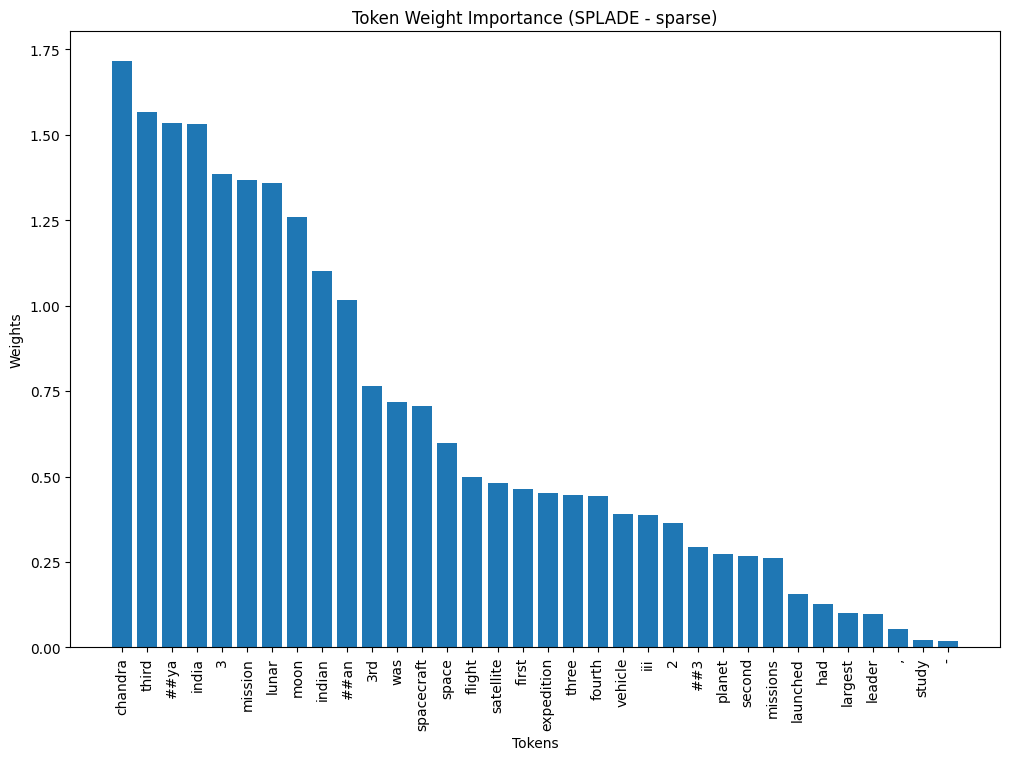

In [39]:
# Test the function with the first SparseEmbedding
#print(json.dumps(get_tokens_and_weights(sparse_embeddings_list[index], tokenizer_qdrant), indent=4))
data = get_tokens_and_weights(sparse_embeddings_list[index], tokenizer_qdrant) # get the data as a dictionary

# extract the tokens and weights
tokens = list(data.keys())
weights = list(data.values())

# create the bar plot using matplotlib
fig = plt.figure(figsize=(12,8))
plt.bar(tokens, weights)
plt.xlabel("Tokens")
plt.ylabel("Weights")
plt.title("Token Weight Importance (SPLADE - sparse)")
plt.xticks(rotation=90)
plt.show()

# Similarity using SPLADE
* We can calculate the cosine sim of documents using SPLADE.

In [27]:
tokens = tokenizer_qdrant(
    documents, return_tensors='pt',
    padding=True, truncation=True
)
output = model(**tokens)
# aggregate the token-level vecs and transform to sparse
vecs = torch.max(
    torch.log(1 + torch.relu(output.logits)) * tokens.attention_mask.unsqueeze(-1), dim=1
)[0].squeeze().detach().cpu().numpy()
vecs.shape

(12, 30522)

In [28]:
import numpy as np

## calculate cosine sim
sim = np.zeros((vecs.shape[0], vecs.shape[0]))

for i, vec in enumerate(vecs):
    sim[i,:] = np.dot(vec, vecs.T) / (
        np.linalg.norm(vec) * np.linalg.norm(vecs, axis=1)
    )

In [29]:
sim

array([[1.        , 0.32153016, 0.51404405, 0.60961455, 0.22416535,
        0.27569529, 0.65539467, 0.30943927, 0.2732738 , 0.25688317,
        0.44862586, 0.53601241],
       [0.32153016, 1.        , 0.24339531, 0.17985865, 0.18393937,
        0.30211219, 0.41624272, 0.24607182, 0.41596079, 0.22003284,
        0.14859869, 0.11952938],
       [0.51404405, 0.24339531, 1.        , 0.45209384, 0.32681954,
        0.10271942, 0.43517902, 0.30899772, 0.15976971, 0.32837856,
        0.38009152, 0.41850084],
       [0.60961473, 0.17985867, 0.4520939 , 1.        , 0.14853424,
        0.13717809, 0.52581584, 0.328381  , 0.17388925, 0.28482312,
        0.5421803 , 0.6667459 ],
       [0.22416535, 0.18393937, 0.32681954, 0.14853421, 1.        ,
        0.05911135, 0.11877272, 0.08297633, 0.14350456, 0.31756467,
        0.12947465, 0.08343616],
       [0.27569532, 0.30211219, 0.10271943, 0.13717809, 0.05911135,
        1.00000012, 0.31695259, 0.07723951, 0.37676278, 0.08167092,
        0.07383032,

Summary:
* Two sentences that are more similar score higher than an irrelevant sentence.

## Plotting the similarity matrix for sentences in a row

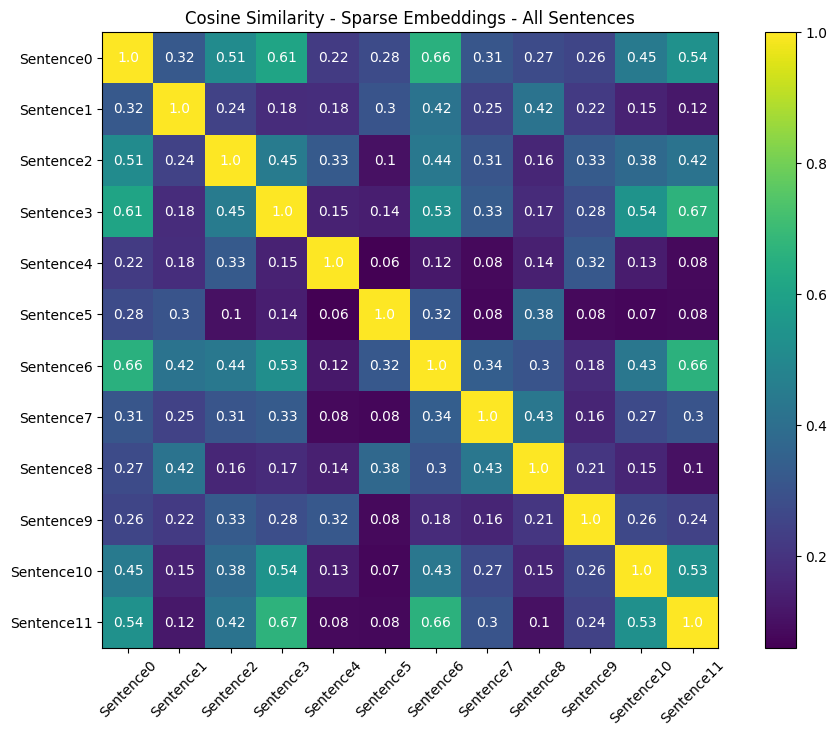

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Assuming 'sim' is your similarity matrix
sim = np.array(sim)

# Create the heatmap with lighter colors
fig = plt.figure(figsize=(12,8))
plt.imshow(sim, cmap='viridis', interpolation='nearest')

# Add labels and annotations
texts = []
for i in range(len(documents)):
  texts.append("Sentence" + str(i))

#texts = ["Sentence 1", "Sentence 2", "Sentence 3"]

for i in range(len(texts)):
    for j in range(len(texts)):
        text = plt.text(j, i, round(sim[i, j], 2),
                       ha="center", va="center", color="w")

plt.title("Cosine Similarity - Sparse Embeddings - All Sentences")
plt.xticks(range(len(texts)), texts, rotation=45)
plt.yticks(range(len(texts)), texts)

plt.colorbar()
plt.show()

# Experiment with 1 row in a dataframe with 3 columns of text.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


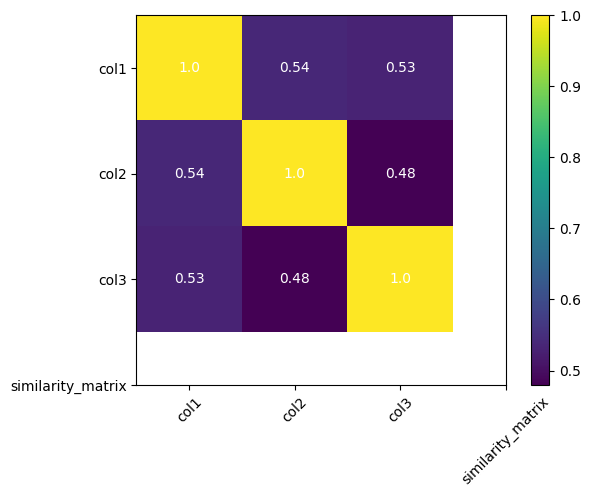

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load the tokenizer and model of choice -- can use same as above
tokenizer = AutoTokenizer.from_pretrained("naver/splade-cocondenser-ensembledistil")
model = AutoModelForMaskedLM.from_pretrained("naver/splade-cocondenser-ensembledistil")

# Sample DataFrame
data = {'col1': ["Sentence 1", "Sentence 4"],
        'col2': ["Sentence 2", "Sentence 5"],
        'col3': ["Sentence 3", "Sentence 6"]}
df = pd.DataFrame(data)

def calculate_similarity(row):
    texts = [row['col1'], row['col2'], row['col3']]
    tokens = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    output = model(**tokens)
    vecs = torch.max(
        torch.log(1 + torch.relu(output.logits)) * tokens.attention_mask.unsqueeze(-1), dim=1
    )[0].squeeze().detach().cpu().numpy()

    sim = np.zeros((vecs.shape[0], vecs.shape[0]))
    for i, vec in enumerate(vecs):
        sim[i,:] = np.dot(vec, vecs.T) / (np.linalg.norm(vec) * np.linalg.norm(vecs, axis=1))

    return sim

# Apply the function to each row of the DataFrame
df['similarity_matrix'] = df.apply(calculate_similarity, axis=1)

# Access and visualize the similarity matrix for the first row
sim = df['similarity_matrix'][0]

# Create the heatmap with lighter colors
plt.imshow(sim, cmap='viridis', interpolation='nearest')

# Add labels and annotations (using column names as labels)
for i in range(sim.shape[0]):
    for j in range(sim.shape[1]):
        text = plt.text(j, i, round(sim[i, j], 2),
                       ha="center", va="center", color="w")

plt.xticks(range(df.shape[1]), df.columns, rotation=45)
plt.yticks(range(df.shape[1]), df.columns)

plt.colorbar()
plt.show()

# histogram example - all 3 columns in a row of text

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


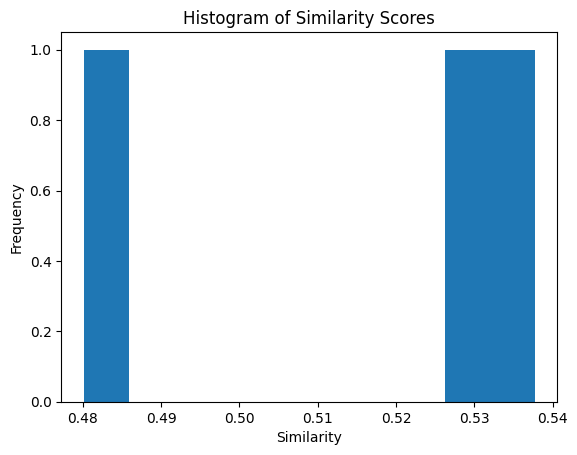

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("naver/splade-cocondenser-ensembledistil")
model = AutoModelForMaskedLM.from_pretrained("naver/splade-cocondenser-ensembledistil")

# Sample DataFrame
data = {'col1': ["Sentence 1", "Sentence 4"],
        'col2': ["Sentence 2", "Sentence 5"],
        'col3': ["Sentence 3", "Sentence 6"]}
df = pd.DataFrame(data)

def calculate_similarity(row):
    texts = [row['col1'], row['col2'], row['col3']]
    tokens = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    output = model(**tokens)
    vecs = torch.max(
        torch.log(1 + torch.relu(output.logits)) * tokens.attention_mask.unsqueeze(-1), dim=1
    )[0].squeeze().detach().cpu().numpy()

    sim = np.zeros((vecs.shape[0], vecs.shape[0]))
    for i, vec in enumerate(vecs):
        sim[i,:] = np.dot(vec, vecs.T) / (np.linalg.norm(vec) * np.linalg.norm(vecs, axis=1))

    return sim

df['similarity_matrix'] = df.apply(calculate_similarity, axis=1)

# Access the similarity matrix for the first row
sim = df['similarity_matrix'][0]

# Flatten the similarity matrix and remove diagonal elements
sim_flat = sim[np.triu_indices(sim.shape[0], k=1)]

# Create the histogram
plt.hist(sim_flat, bins=10)
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.title("Histogram of Similarity Scores")
plt.show()

# Large df example
* Calculate similarity across a row for all 3 output responses

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


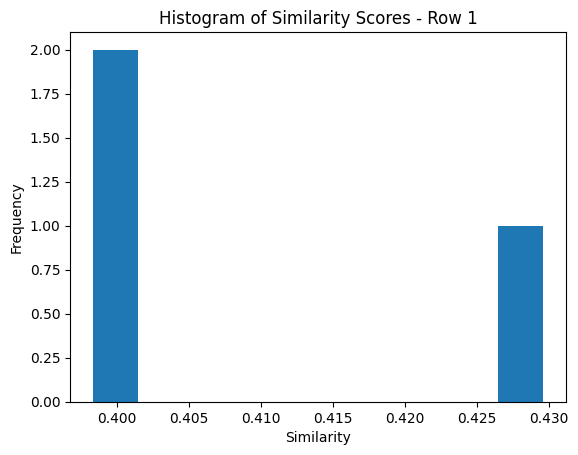

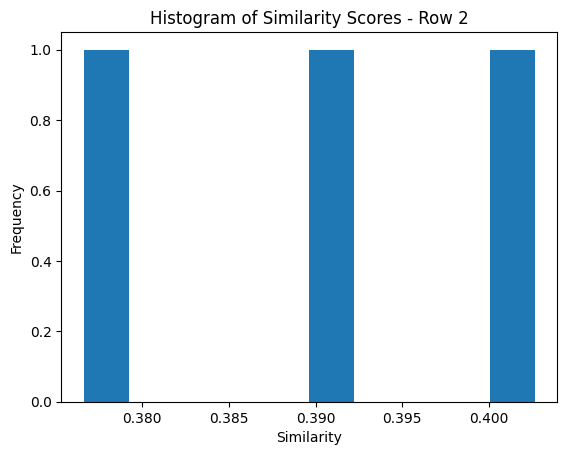

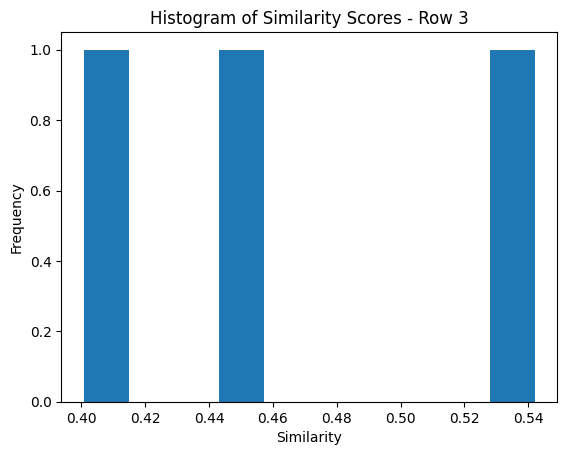

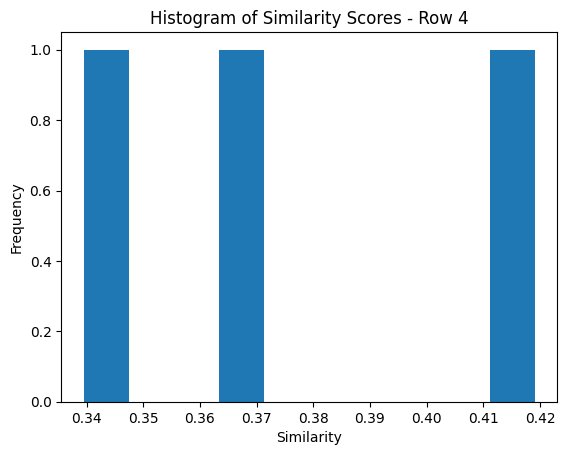

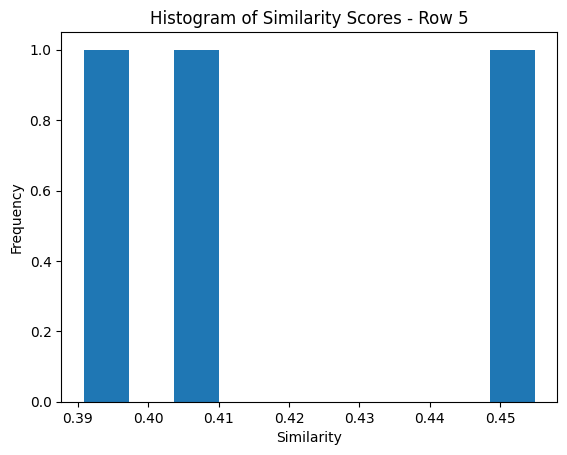

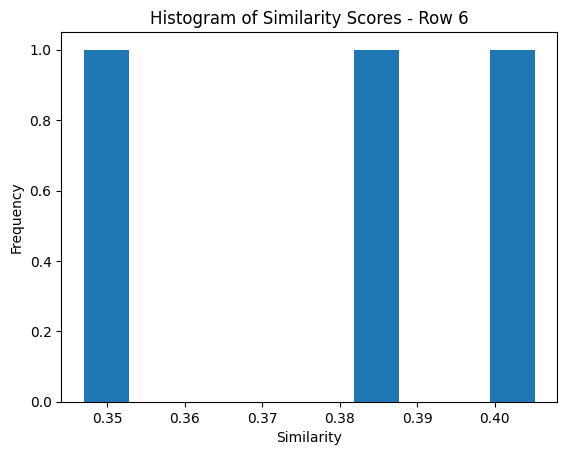

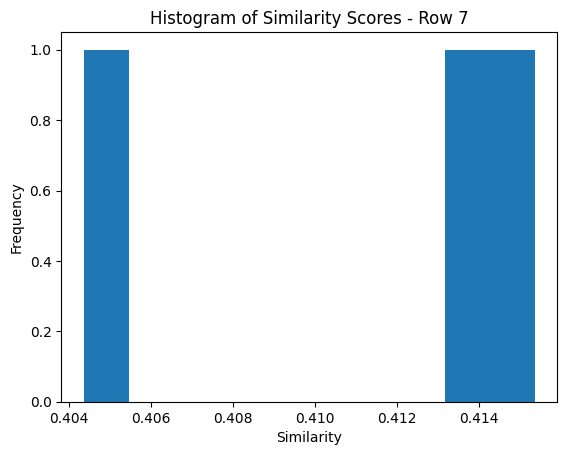

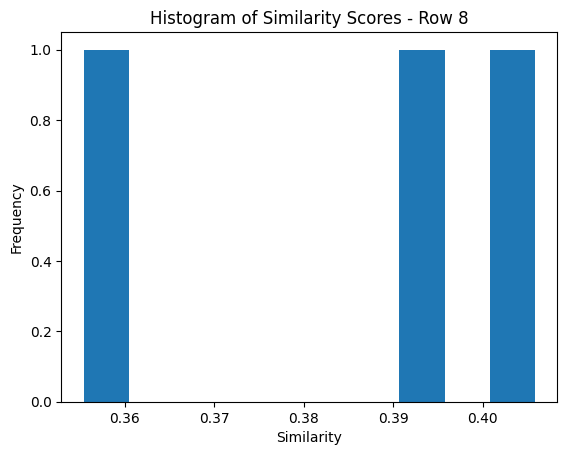

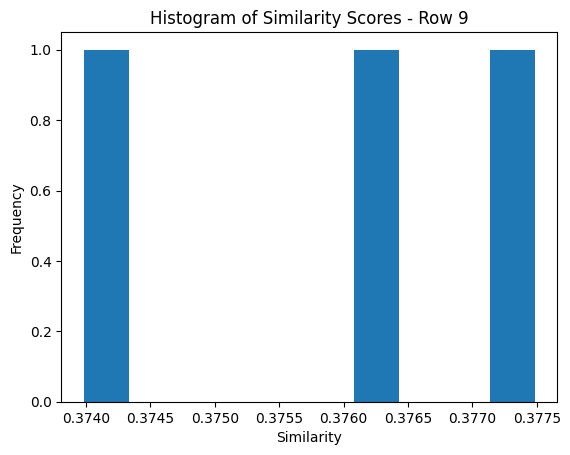

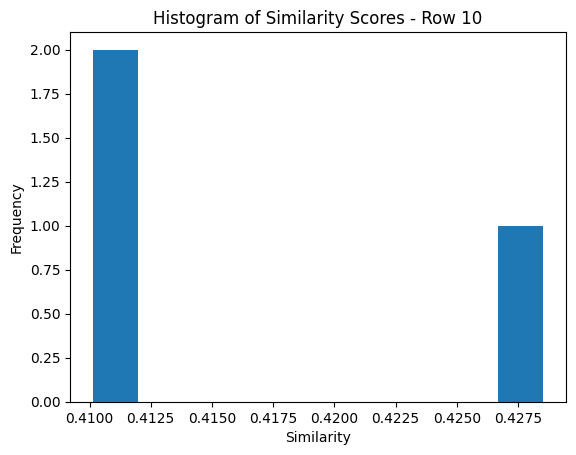

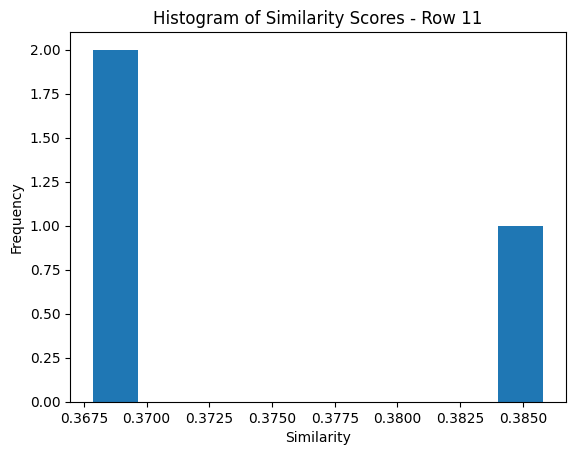

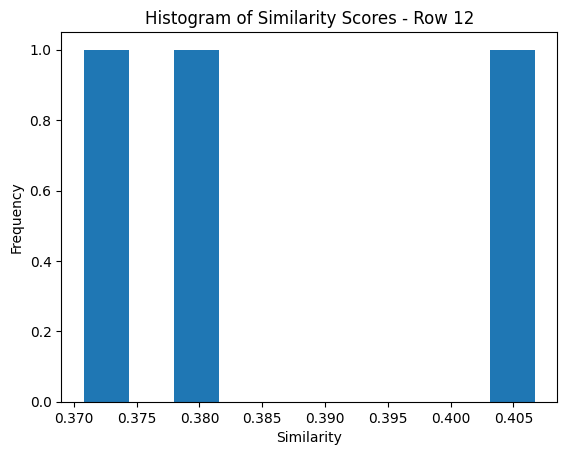

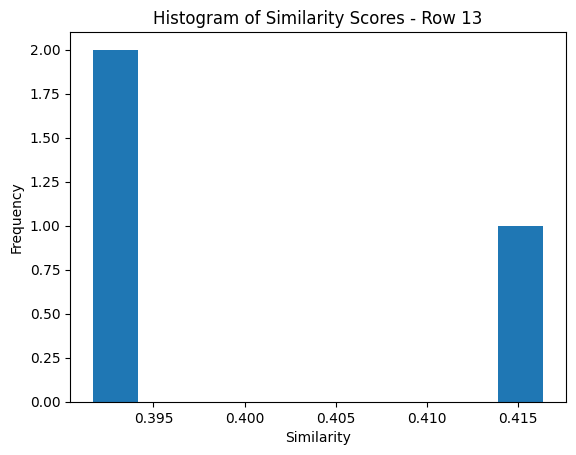

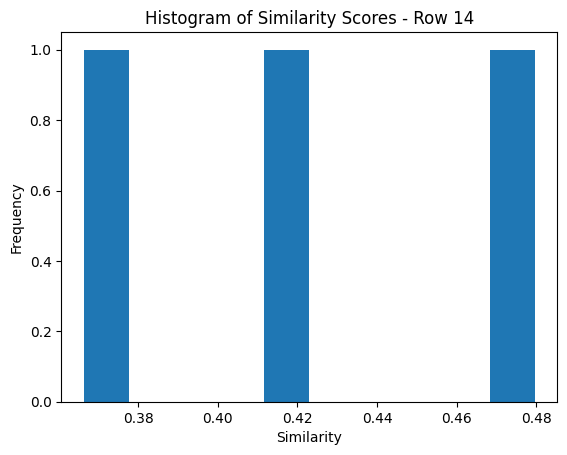

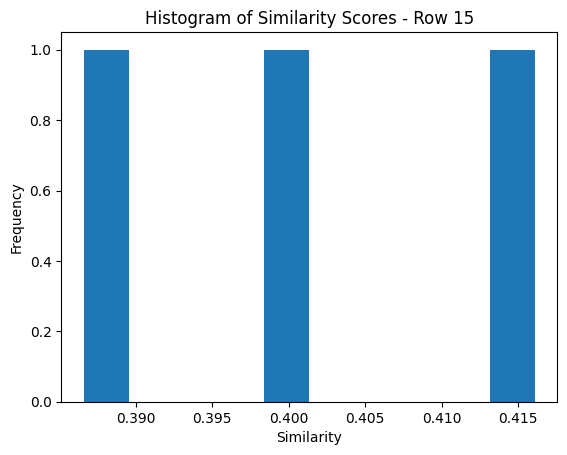

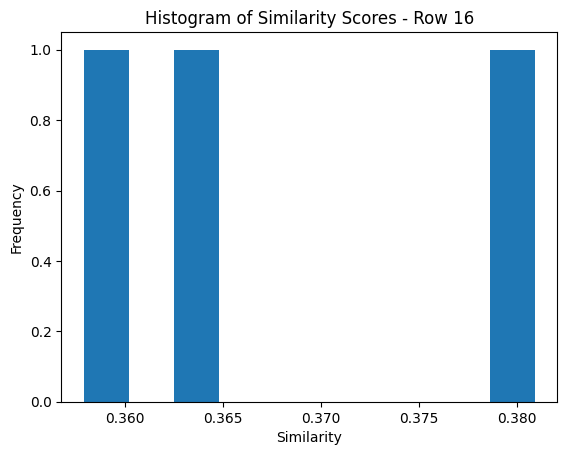

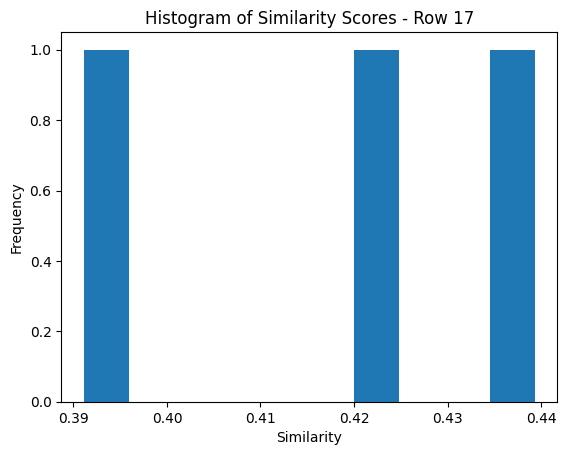

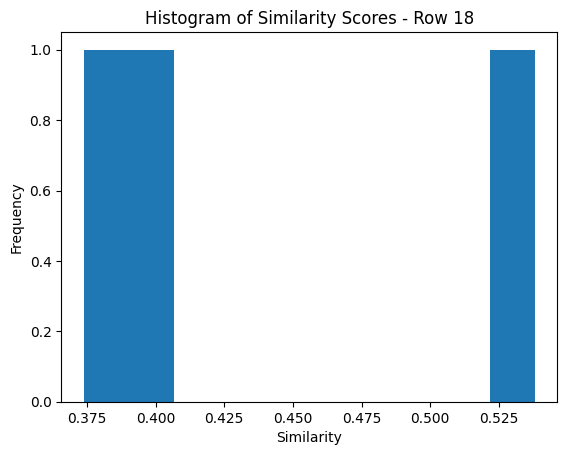

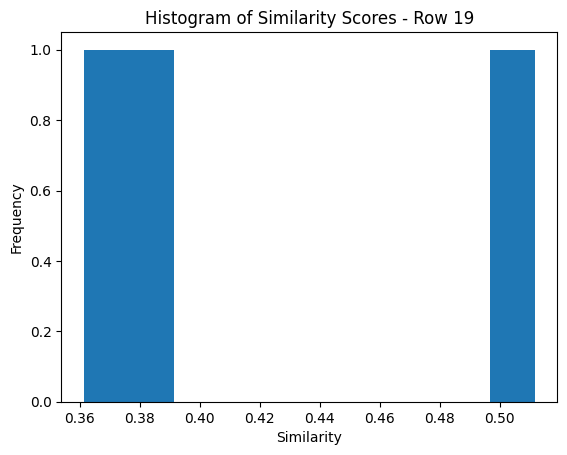

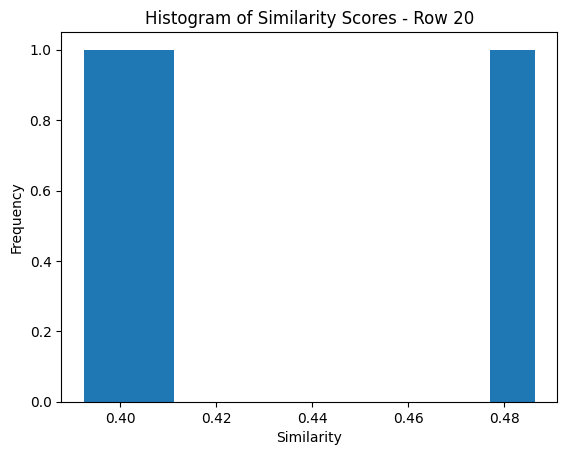

Minimum similarity: 0.33951863646507263
Maximum similarity: 0.5420230627059937
Average similarity: 0.40376783112684883


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("naver/splade-cocondenser-ensembledistil")
model = AutoModelForMaskedLM.from_pretrained("naver/splade-cocondenser-ensembledistil")

# Sample DataFrame with 20 rows
df = pd.DataFrame({
    'col1': ["Sentence " + str(i) for i in range(1, 21)],
    'col2': ["Sentence " + str(i) for i in range(21, 41)],
    'col3': ["Sentence " + str(i) for i in range(41, 61)]
})

def calculate_similarity(row):
    texts = [row['col1'], row['col2'], row['col3']]
    tokens = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    output = model(**tokens)
    vecs = torch.max(
        torch.log(1 + torch.relu(output.logits)) * tokens.attention_mask.unsqueeze(-1), dim=1
    )[0].squeeze().detach().cpu().numpy()

    sim = np.zeros((vecs.shape[0], vecs.shape[0]))
    for i, vec in enumerate(vecs):
        sim[i,:] = np.dot(vec, vecs.T) / (np.linalg.norm(vec) * np.linalg.norm(vecs, axis=1))

    return sim

df['similarity_matrix'] = df.apply(calculate_similarity, axis=1)

# Create multiple plots for each row
for i in range(df.shape[0]):
    sim = df['similarity_matrix'][i]
    sim_flat = sim[np.triu_indices(sim.shape[0], k=1)]

    plt.figure()
    plt.hist(sim_flat, bins=10)
    plt.xlabel("Similarity")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Similarity Scores - Row {i+1}")
    plt.show()

# Aggregate results
all_similarities = []
for i in range(df.shape[0]):
    sim = df['similarity_matrix'][i]
    sim_flat = sim[np.triu_indices(sim.shape[0], k=1)]
    all_similarities.extend(sim_flat)

min_sim = np.min(all_similarities)
max_sim = np.max(all_similarities)
avg_sim = np.mean(all_similarities)

print(f"Minimum similarity: {min_sim}")
print(f"Maximum similarity: {max_sim}")
print(f"Average similarity: {avg_sim}")

In [45]:
df.head()

,col1,col2,col3,similarity_matrix
0,Sentence 1,Sentence 21,Sentence 41,"[[0.9999998211860657, 0.4296467900276184, 0.40..."
1,Sentence 2,Sentence 22,Sentence 42,"[[0.9999999403953552, 0.3908202350139618, 0.37..."
2,Sentence 3,Sentence 23,Sentence 43,"[[1.0, 0.4509214758872986, 0.5420230627059937]..."
3,Sentence 4,Sentence 24,Sentence 44,"[[0.9999999403953552, 0.41907402873039246, 0.3..."
4,Sentence 5,Sentence 25,Sentence 45,"[[1.0, 0.45490124821662903, 0.39084392786026],..."


## All similarities across all rows

In [46]:
all_similarities = [] # changed to a list
for i in range(df.shape[0]):
    sim = df['similarity_matrix'][i]
    sim_flat = sim[np.triu_indices(sim.shape[0], k=1)] # extract upper triangle of the matrix
    all_similarities.extend(sim_flat) # add the values to the list

all_similarities = np.array(all_similarities) # convert the list to a numpy array

avg_similarities = np.mean(all_similarities) # calculate the average similarity

print(f"Average similarity: {avg_similarities}")

Average similarity: 0.40376783112684883


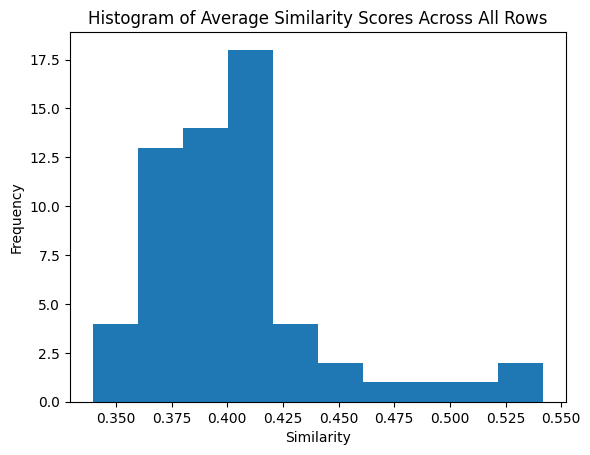

In [47]:

# Assuming 'all_similarities' is a list or array of similarity values
plt.hist(all_similarities, bins=10)
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.title("Histogram of Average Similarity Scores Across All Rows")
plt.show()

In [48]:
all_similarities

array([0.42964679, 0.40059036, 0.39829588, 0.39082024, 0.37663054,
       0.4026413 , 0.45092148, 0.54202306, 0.40074462, 0.41907403,
       0.33951864, 0.37039471, 0.45490125, 0.39084393, 0.40793177,
       0.40518343, 0.3469916 , 0.38248149, 0.4153648 , 0.41395202,
       0.40436807, 0.3914381 , 0.35545623, 0.40581393, 0.37398341,
       0.37748313, 0.37627682, 0.42853656, 0.41025072, 0.4101254 ,
       0.36793685, 0.36784682, 0.38581893, 0.37079096, 0.40670308,
       0.37822309, 0.39385316, 0.41637808, 0.39166442, 0.36639166,
       0.41414011, 0.47959757, 0.38659438, 0.41609395, 0.39906633,
       0.38091108, 0.35789782, 0.3631072 , 0.42421812, 0.39110643,
       0.43932635, 0.37386498, 0.40379861, 0.53809166, 0.36130062,
       0.38125151, 0.51171595, 0.40697694, 0.39242241, 0.4862965 ])

# Moving Average cosine similarity for each column

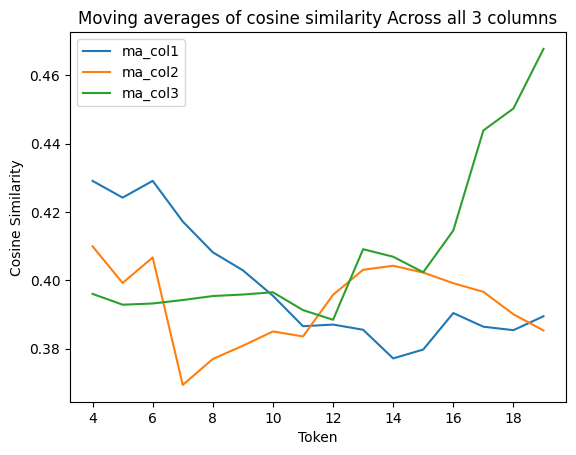

In [53]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is named 'df'

def get_similarity_scores(row):
  sim_matrix = row['similarity_matrix']
  return [sim_matrix[0,1], sim_matrix[0,2], sim_matrix[1,2]]

# Extract similarity scores for each column
df[['sim_col1', 'sim_col2', 'sim_col3']] = df.apply(get_similarity_scores, axis=1, result_type="expand")

# Calculate moving averages
df['ma_col1'] = df['sim_col1'].rolling(window=5).mean()
df['ma_col2'] = df['sim_col2'].rolling(window=5).mean()
df['ma_col3'] = df['sim_col3'].rolling(window=5).mean()

# Plot the moving averages

df[['ma_col1', 'ma_col2', 'ma_col3']].plot()
plt.title("Moving averages of cosine similarity Across all 3 columns")
plt.ylabel("Cosine Similarity")
plt.xlabel("Token")
plt.show();

## Moving Average cosine similarity across each row in df

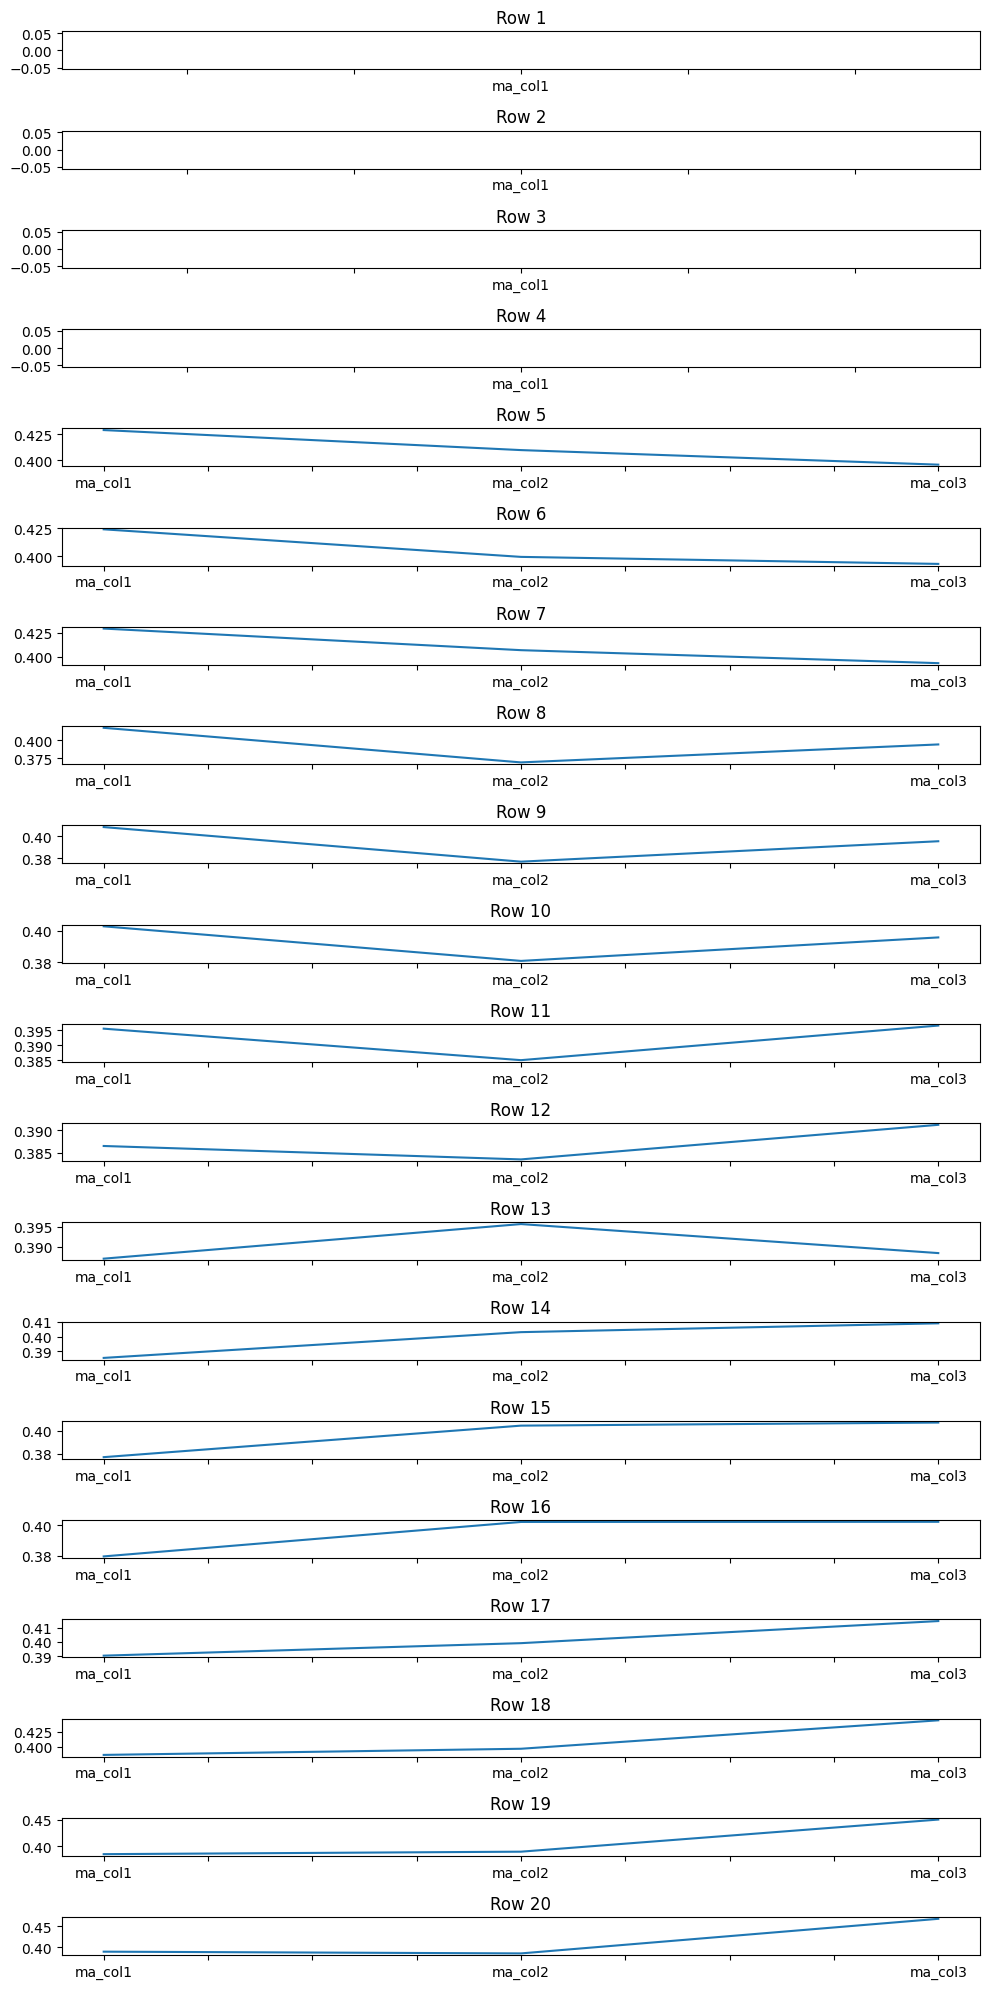

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## function to compute similarity scores

def get_similarity_scores(row):
  sim_matrix = row['similarity_matrix']
  return [sim_matrix[0,1], sim_matrix[0,2], sim_matrix[1,2]]

# Extract similarity scores for each column
df[['sim_col1', 'sim_col2', 'sim_col3']] = df.apply(get_similarity_scores, axis=1, result_type="expand")

# Calculate moving averages
df['ma_col1'] = df['sim_col1'].rolling(window=5).mean()
df['ma_col2'] = df['sim_col2'].rolling(window=5).mean()
df['ma_col3'] = df['sim_col3'].rolling(window=5).mean()

# Create subplots for each row
fig, axes = plt.subplots(nrows=df.shape[0], ncols=1, figsize=(10, 20))

for i in range(df.shape[0]):
  df[['ma_col1', 'ma_col2', 'ma_col3']].iloc[i].plot(ax=axes[i])
  axes[i].set_title(f'Row {i+1}')

plt.tight_layout()
plt.show()